In [22]:
import pandas, numpy, itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (TfidfVectorizer, 
    CountVectorizer, HashingVectorizer)
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
## Load the Dataset from AWS S3 Bucket Location.
## https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv

df = pandas.read_csv('Dataset/fake_or_real_news.csv')

print(df.shape)

(6335, 4)


In [3]:
print(df.head())

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [4]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [5]:
## Get the labels
labels = df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [6]:
## Split the Dataset into Training Dataset 80% and Testing Dataset 20%
x_train, x_test, y_train, y_test = train_test_split(df['text'], 
    labels, test_size = 0.2, random_state = 7)

In [7]:
## Initialize a CountVectorizer
count_vectorizer = CountVectorizer(stop_words = 'english')

## Fit and Transform Train & Test Dataset
count_train = count_vectorizer.fit_transform(x_train) 
count_test = count_vectorizer.transform(x_test)

In [8]:
## Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7)

## Fit and Transform Train & Test Dataset
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In [9]:
## Initialize a Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)

## Predict on the Test Dataset and Calculate Accuracy
y_pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f' Accuracy: { round(score * 100, 2) } %')

 Accuracy: 84.06 %


In [10]:
last_score = 0
for alpha in numpy.arange(0, 1, 0.1):
    nb_classifier = MultinomialNB(alpha = alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {} %".format(alpha, round(score * 100, 2) ))

Alpha: 0.00 Score: 88.79 %
Alpha: 0.10 Score: 90.45 %
Alpha: 0.20 Score: 90.06 %

c:\python382\lib\site-packages\sklearn\naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '



Alpha: 0.30 Score: 89.42 %
Alpha: 0.40 Score: 88.24 %
Alpha: 0.50 Score: 87.37 %
Alpha: 0.60 Score: 86.5 %
Alpha: 0.70 Score: 85.79 %
Alpha: 0.80 Score: 84.77 %
Alpha: 0.90 Score: 84.37 %


In [11]:
## This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, normalize = False, 
                          title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", 
                 color = "white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
## Build Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
conf_matrix

array([[450, 188],
       [ 14, 615]], dtype=int64)

Confusion matrix, without normalization


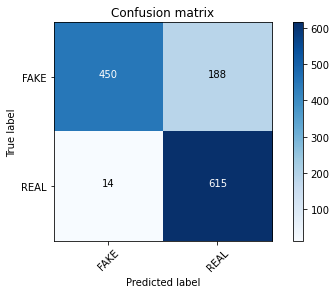

In [13]:
plot_confusion_matrix(conf_matrix, classes = ['FAKE', 'REAL'])

In [14]:
## Initialize a PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter = 50)
linear_clf.fit(tfidf_train, y_train)

## Predict on the Test Dataset and Calculate Accuracy
y_pred = linear_clf.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f' Accuracy: { round(score * 100, 2) } %')

 Accuracy: 92.66 %


In [15]:
## Build Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
conf_matrix

array([[587,  51],
       [ 42, 587]], dtype=int64)

Confusion matrix, without normalization


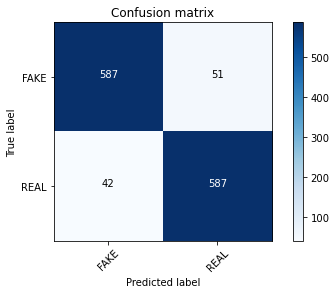

In [16]:
plot_confusion_matrix(conf_matrix, classes = ['FAKE', 'REAL'])

In [17]:
'''
Identify most important features if given a vectorizer and binary 
classifier. Set n to the number of weighted features you would like to show. 
(Note: current implementation merely prints and does not return top classes.)
'''

def get_feature_binary_classifier(vectorizer, classifier, n = 100):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[ : n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n : ]
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()
    
    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)
        
get_feature_binary_classifier(tfidf_vectorizer, linear_clf, n = 30)

FAKE -5.7744317761542865 2016
FAKE -4.929001370437367 october
FAKE -3.422630229264082 hillary
FAKE -3.298370582452161 election
FAKE -3.272090010067587 share
FAKE -3.1273544484832456 article
FAKE -3.112128241907911 november
FAKE -2.712708661904027 establishment
FAKE -2.5218198109575476 print
FAKE -2.4830024182022434 source
FAKE -2.4778012733649937 advertisement
FAKE -2.462457485041364 mosul
FAKE -2.3178042429033243 snip
FAKE -2.0780196862170706 podesta
FAKE -1.9842625521244361 oct
FAKE -1.934825881085166 26
FAKE -1.9248297390375049 fbi
FAKE -1.8816116004244479 corporate
FAKE -1.8680979547646264 wikileaks
FAKE -1.8205739808087111 email
FAKE -1.8061887100761038 ayotte
FAKE -1.7410880700003801 daesh
FAKE -1.7340918718656666 uk
FAKE -1.7199560665179263 28
FAKE -1.7187521286791296 just
FAKE -1.702872490292218 dr
FAKE -1.7011413129682922 mainstream
FAKE -1.6819432579658826 watch
FAKE -1.6262452481452085 russia
FAKE -1.6133553339822466 corruption

REAL 4.659537675065677 said
REAL 3.20696562078

In [18]:
feature_names = tfidf_vectorizer.get_feature_names()
sorted(zip(clf.coef_[0], feature_names), reverse = True)[:20]

[(-6.1534666336097965, 'trump'),
 (-6.429270250326494, 'said'),
 (-6.594324961783829, 'clinton'),
 (-6.997996276351331, 'obama'),
 (-7.140381107128312, 'sanders'),
 (-7.167374113253323, 'campaign'),
 (-7.169454568140229, 'president'),
 (-7.229137777744787, 'cruz'),
 (-7.231745755670421, 'republican'),
 (-7.2459644886850905, 'state'),
 (-7.30874688046506, 'party'),
 (-7.378959092544026, 'new'),
 (-7.399757488354263, 'people'),
 (-7.469304622598987, 'percent'),
 (-7.50967627278197, 'house'),
 (-7.5100437404602935, 'bush'),
 (-7.534089256487041, 'republicans'),
 (-7.575843239244211, 'voters'),
 (-7.590433287579174, 'rubio'),
 (-7.617702270185296, 'states')]

In [34]:
## Initialize a HashingVectorizer
hash_vectorizer = HashingVectorizer(stop_words = 'english')
hash_train = hash_vectorizer.fit_transform(x_train)
hash_test = hash_vectorizer.transform(x_test)

## Predict on the Test Dataset and Calculate Accuracy
clf = PassiveAggressiveClassifier(n_iter_no_change = 50)
clf.fit(hash_train, y_train)
y_pred = clf.predict(hash_test)
score = accuracy_score(y_test, y_pred)
print(f' Accuracy: { round(score * 100, 2) } %')

 Accuracy: 91.95 %


In [32]:
## Build Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
conf_matrix

array([[583,  55],
       [ 44, 585]], dtype=int64)

In [28]:
help(PassiveAggressiveClassifier)

Help on class PassiveAggressiveClassifier in module sklearn.linear_model._passive_aggressive:

class PassiveAggressiveClassifier(sklearn.linear_model._stochastic_gradient.BaseSGDClassifier)
 |  PassiveAggressiveClassifier(C=1.0, fit_intercept=True, max_iter=1000, tol=0.001, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, shuffle=True, verbose=0, loss='hinge', n_jobs=None, random_state=None, warm_start=False, class_weight=None, average=False)
 |  
 |  Passive Aggressive Classifier
 |  
 |  Read more in the :ref:`User Guide <passive_aggressive>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  C : float
 |      Maximum step size (regularization). Defaults to 1.0.
 |  
 |  fit_intercept : bool, default=False
 |      Whether the intercept should be estimated or not. If False, the
 |      data is assumed to be already centered.
 |  
 |  max_iter : int, optional (default=1000)
 |      The maximum number of passes over the training data (aka epochs).
 |      It only impacts the